<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/1_%D0%9E%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C_%D1%81%D1%82%D0%B0%D1%80%D1%82%D0%BE%D0%B2%D1%8B%D0%B5_%D0%B2%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представленный Colab Notebook является частью серии наработок по исследованиям в области практической оценки судопроизводства методами численного анализа, проводимых [НУЛ анализа данных правоприменения НИУ ВШЭ](https://adp.hse.ru/). 

Контактная информация рабочей группы: gkrasnozhenov@hse.ru (Григорий Григорьевич Красноженов, ЗавЛаб НУЛ АДП), timmariya541@gmail.com (Мария Тимонина, стажер, ответственный за текущую задачу)

Материалом для анализа служат **данные системы арбитражных судов РФ**.

---

### Стандартный пролог подключения библиотек и загрузки базы данных в pandas DataFrame:

In [ ]:
import numpy as np          # библиотека для матриц и математики
import pandas as pd         # библиотека для работы с табличками
from scipy import stats     # модуль для работы со статистикой
from matplotlib import colors

#библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # стиль графиков
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/ArbitragePracticeMid.csv"
df = pd.read_csv(path, sep=',')

In [ ]:
df.head()

,НомерДела,Суд,ВидСпора,КатегорияСпора,СуммаИска,СуммаВзысканий,НачалоДела,ПродолжительностьДела
0,34925-13/1941,АС Воронежской области,А,О взыскании обязательных платежей и санкций по...,0.0,0.0,2014-01-31,48
1,А01-120/2014,АС Республики Адыгея,Г,О признании права собственности,0.0,0.0,2014-01-31,8
2,А01-121/2014,АС Республики Адыгея,Г,О неисполнении или ненадлежащем исполнении обя...,34484.9,36484.9,2014-01-31,670
3,А01-122/2014,АС СКО,Г,Иные экономические споры,132000.0,176979.0,2014-01-31,419
4,А01-123/2014,АС Республики Адыгея,А,О привлечении к административной ответственности,0.0,0.0,2014-01-31,42


## **Описание задачи**

*   Выгрузка данных и очистка от повторяющихся значений

---
---

#### Кастомизация для удобства обработки

* Переименование столбцов
* Добавление столбца Дат Окончания срока по каждому делу "Конец"

In [ ]:
df = df.rename(columns={'НомерДела': 'Номер Дела', 'ВидСпора': 'Вид Спора', 'КатегорияСпора': 'Категория Спора', 'ВидСпора': 'Вид Спора'})
df = df.rename(columns={'СуммаИска': 'Сумма Иска', 'СуммаВзысканий': 'Сумма Взысканий', 'НачалоДела': 'Начало', 'ПродолжительностьДела': 'Продолжительность'})

* Для упрощения работы с записями как с временными рядами добавяется столбец "Конец", в котором будет храниться сумма даты начала и продолжительности рассмотрения спора

In [ ]:
# каст из строк к датам - подсказка для python, чтобы сократить
# количество приведений типов при дальнейших вычислениях
df['Начало'] = pd.to_datetime(df['Начало'])
df['Продолжительность'] = pd.to_timedelta(df['Продолжительность'], unit='D')

df['Конец'] = df['Начало'] + df['Продолжительность']

#### Теперь обрабатываемый датасет хранится в следующем виде:

In [ ]:
df.head()

,Номер Дела,Суд,Вид Спора,Категория Спора,Сумма Иска,Сумма Взысканий,Начало,Продолжительность,Конец
0,34925-13/1941,АС Воронежской области,А,О взыскании обязательных платежей и санкций по...,0.0,0.0,2014-01-31,48 days,2014-03-20
1,А01-120/2014,АС Республики Адыгея,Г,О признании права собственности,0.0,0.0,2014-01-31,8 days,2014-02-08
2,А01-121/2014,АС Республики Адыгея,Г,О неисполнении или ненадлежащем исполнении обя...,34484.9,36484.9,2014-01-31,670 days,2015-12-02
3,А01-122/2014,АС СКО,Г,Иные экономические споры,132000.0,176979.0,2014-01-31,419 days,2015-03-26
4,А01-123/2014,АС Республики Адыгея,А,О привлечении к административной ответственности,0.0,0.0,2014-01-31,42 days,2014-03-14


## **Базовые проверки на корректность**

#### Содержит ли база **строки-дубликаты**? 

Если да, то следует исключить повторения - каждое дело должно учитываться ровно 1 раз

In [ ]:
len1 = df.shape[0]
print('Записей до чистки дубликатов:', len1)
df = df.drop_duplicates()
len2 = df.shape[0]
print('После чистки:', len2)

if (len1 > len2) :
  print('\nОбнаружены дубликаты записей! Исключено ', (len1 - len2), ' дел')
else :
  print('\nДанные чистые! Дубликатов нет')

Записей до чистки дубликатов: 3628165
После чистки: 3628165

Данные чистые! Дубликатов нет



#### **Про сроки расмотрения**
При ручном вводе информации о деле в базу КАД случаются ошибки в наборе дат. Отследить и удалить из рассмотрения возможно только записи, содержащие противоречивую информацию - **отрицательное знаение в столбце "Продолжительность"** (дата конца меньше даты начала).

In [ ]:
df.groupby('Вид Спора')[['Продолжительность'] ].agg(['min', 'max'])

Продолжительность          
                        min       max
Вид Спора                            
А               -42450 days 1203 days
Б               -42081 days 1198 days
Бф                  -5 days  923 days
Г               -42487 days 1198 days
И               -42051 days 1198 days
Ф                    1 days 1151 days

Действительно, наш датасет содержит такие записи, причем они присутствуют практически во всех видах споров. Сохраним информацию о них в dataframe **error_dates** и подсчитаем их количество в каждом из судов (~регионов). Выведем для наглядности топ судов с ошибками в датах.

In [ ]:
error_dates = df[df['Начало'] > df['Конец']]
error_regions = error_dates.groupby('Суд')['Номер Дела'].agg(['count']).sort_values(by=['count'], ascending=False)
error_regions[:10]

,count
Суд,
АС Республики Крым,187
АС Томской области,179
АС города Севастополя,130
АС города Москвы,104
АС Кировской области,32
АС Новосибирской области,26
АС Омской области,8
АС Ярославской области,8
АС Республики Марий Эл,7


Теперь уберем их из рассмотрения, очистив данные.

In [ ]:
df = df[df['Начало'] <= df['Конец']]
len3 = df.shape[0]
if (len2 > len3) :
  print('Ошибки ввода дат в ', (len2 - len3), ' записях')
  print('\nИтого,', (len2 - len3), ' строк удалены из базы, осталось:', df.shape[0])
else :
  print('Данные чистые! Во всех делах дата конца больше или совпадает с датой начала')

Ошибки ввода дат в  778  записях

Итого, 778  строк удалены из базы, осталось: 3627387


Проверим, что функции отработали корректно и больше отрицательных сроков нет:

In [ ]:
df.groupby('Вид Спора')[['Продолжительность'] ].agg(['min', 'max'])

Продолжительность          
                        min       max
Вид Спора                            
А                    0 days 1203 days
Б                    1 days 1198 days
Бф                   1 days  923 days
Г                    0 days 1198 days
И                    1 days 1198 days
Ф                    1 days 1151 days

**!** Может быть, имеет место и обратное? Ошибки в сроках, связанные с выбросами "в плюс", **переполнения по длительности**
  > Присутствуют ли в базе такие записи о делах, продолжительность рассмотрения которых не является типичной/допустимой для спора этой категории или подобное? Если да, то действительно ли имел место такой прецедент или в данных есть ошибка?

Как видно из группировки по Видам спора ячейкой выше, наибольшая продолжительность рассмотрения одного дела составляет:

In [ ]:
max_len = df['Продолжительность'].max().days
print(max_len, "дня")

1203 дня


Как распределены значения величины "Продолжительность"? Длинные ли хвосты? Построим **гистограмму**

In [ ]:
#если не работает, рас(/за)комментируете строку ниже
df['Продолжительность'] = df['Продолжительность'].dt.days

int_days = df['Продолжительность']
log_days = df['Продолжительность'].apply(lambda x: np.log(x + 1))

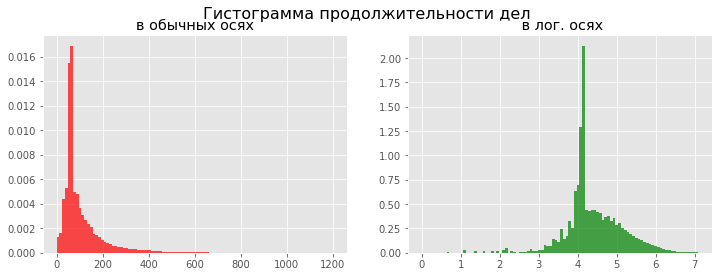

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

#N, bins, patches = 
ax1.hist(int_days, bins=100, density=True, color="r", alpha=0.7);

#int_days.plot(kind='kde', linewidth=4)
ax1.set_title("в обычных осях");

ax2.hist(log_days, bins=100, density=True, color="g", alpha=0.7);
#log_days.plot(kind='kde', linewidth=4)
ax2.set_title(" в лог. осях");

fig.suptitle("Гистограмма продолжительности дел", fontsize=16);

306.0

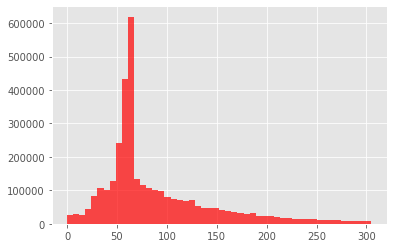

In [ ]:
q = df['Продолжительность'].quantile(0.95)
df_cut = df[df['Продолжительность'] < q]['Продолжительность']
df_cut.hist(bins=50, color="r", alpha=0.7);
q

**Микровывод:** Распределение со скачками, некоторые пока не выясненные обстоятельства ("подгон отчетности" ?) искажают выборку

In [ ]:
df.groupby('Продолжительность')['Продолжительность'].agg(['count']).sort_values(by='count', ascending=False)[:10]

,count
Продолжительность,
62,202373
63,139603
61,106495
60,99270
64,98527
57,85199
58,76296
59,71425
56,60346


#### **Про суммы Иска и Взыскания**

Следует принципиально различать два крайних типа дел:

1) "Сумма Иска положительна, **Сумма Взыскания равна нулю**" : истец получил отказ в удовлетворении своего прошения о возмещении..... как это сказать? К юристам

2) "**Сумма Иска ноль**, Сумма Взыскания больше нуля" : состав дела предполагает материальное возмещение, однако желаемый размер не был указан истцом в заявлении

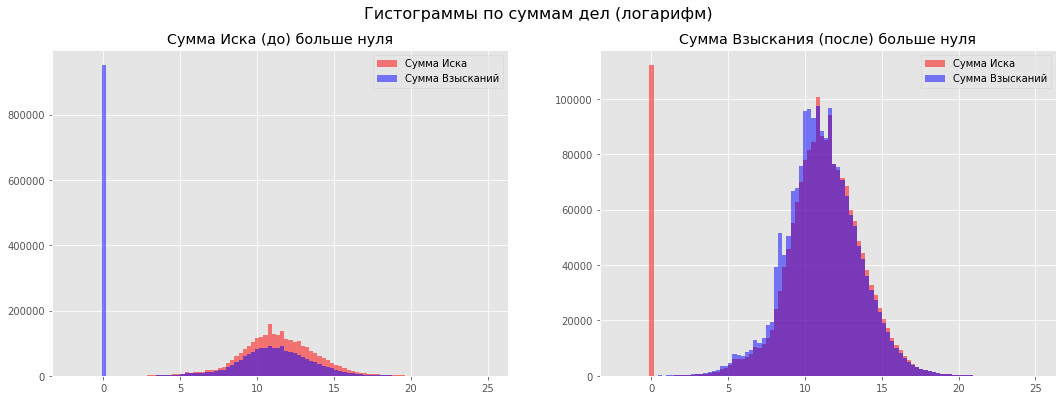

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

ax1.hist(df[df['Сумма Иска'] > 0]['Сумма Иска'].apply(lambda x: np.log(x + 1)), bins=100, color="r", alpha=0.5, label='Сумма Иска', range=[-2, 25]);
ax1.hist(df[df['Сумма Иска'] > 0]['Сумма Взысканий'].apply(lambda x: np.log(x + 1)), bins=100, color="b", alpha=0.5, label='Сумма Взысканий', range=[-2, 25]);
ax1.set_title("Сумма Иска (до) больше нуля");

ax1.legend()

ax2.hist(df[df['Сумма Взысканий'] > 0]['Сумма Иска'].apply(lambda x: np.log(x + 1)), bins=100, color="r", alpha=0.5, label='Сумма Иска', range=[-2, 25]);
ax2.hist(df[df['Сумма Взысканий'] > 0]['Сумма Взысканий'].apply(lambda x: np.log(x + 1)), bins=100, color="b", alpha=0.5, label='Сумма Взысканий', range=[-2, 25]);
ax2.set_title("Сумма Взыскания (после) больше нуля");

ax2.legend()

fig.suptitle("Гистограммы по суммам дел (логарифм)", fontsize=16);

In [ ]:
print('Всего дел:', df.shape[0])
print('Из них сумма иска указана как 0.00 в', (df['Сумма Иска'] == 0).sum(), 'записях')
print('Тогда ненулевых осталось:', df.shape[0] - (df['Сумма Иска'] == 0).sum())

Всего дел: 3627387
Из них сумма иска указана как 0.00 в 898165 записях
Тогда ненулевых осталось: 2729222


In [ ]:
df_wnulls = df[df['Сумма Иска'] > 0]
df_wnulls[df_wnulls['Сумма Взысканий'] == 0].shape[0] / df_wnulls.shape[0]

0.3487019377683457

Изобразим на координатной плоскости информацию о делах, в которых истец изначально указал **ненулевую сумму возмещения** (иные мы пока не обрабатываем, откладывая их в отдельную категорию) в осях (Сумма Иска, Сумма Взысканий).

In [ ]:
def plot_props_sums(ax, upper_bound) :
    df_curr = df_wnulls[(df_wnulls['Сумма Иска']< upper_bound )  & (df_wnulls['Сумма Взысканий'] < upper_bound )]

    ax.plot(df_curr['Сумма Иска'], df_curr['Сумма Взысканий'], 'k.')
    ax.set_xlabel('Сумма Иска')
    ax.set_ylabel('Сумма Взысканий')
    return df_curr.shape[0]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(21, 7))
print("Множество точек на первом графике соответствует", plot_props_sums(ax1, 10**10), 
      "записям, на втором ", plot_props_sums(ax2, 10**9),
      ", на третьем", plot_props_sums(ax3, 10**8))

#fig.suptitle("Суммы, как бы это обозвать...", fontsize=16);

Множество точек на первом графике соответствует 2729140 записям, на втором  2728244 , на третьем 2718396


Для наглядности ни на одном из графиков также не отображены точки, соответствующие спорам, в которых любая из двух сумм превышает **10 млрд. рублей.** Таких дел менее 100, а именно 50 по сумме Иска и 46 по сумме Взыскания. Есть основания предполагать, что порядок сумм, указанных в этих записях, слишком велик и не соответствует реалиам российского судопроизводства, поэтому можно подозревать наличие ошибок при занесении в базу КАД.

In [ ]:
(df['Сумма Иска'] > 10**10 ).sum(), (df['Сумма Взысканий'] > 10**10 ).sum()

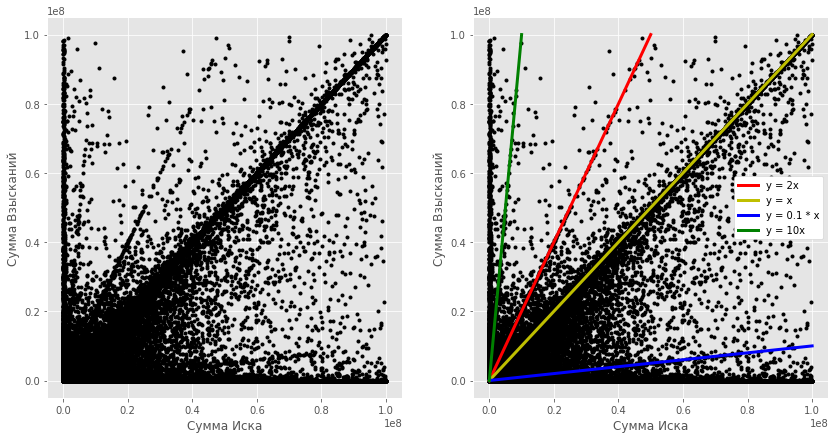

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))
plot_props_sums(ax1, 10**8)
plot_props_sums(ax2, 10**8)

x = np.linspace(0, 10**8, 1000)
line1, = ax2.plot(x / 2, x, 'r', linewidth=3.0)
line1.set_label('y = 2x')
line2, = ax2.plot(x, x, 'y', linewidth=3.0)
line2.set_label('y = x')
line3, = ax2.plot(x, x / 10, 'b', linewidth=3.0)
line3.set_label('y = 0.1 * x')
line4, = ax2.plot(x / 10, x, 'g', linewidth=3.0)
line4.set_label('y = 10x')
ax2.legend(facecolor='white', framealpha=1)

Существование линии с коэфф. 1 (Сумма Иска == Сумма Взыскания) ожидаемо (на нее попадают все дела с удовлетворенным полностью иском). Но есть и  другие прямые, сформированные реальными данными, которые показывают устойчивые коэффициенты соотношения иска и взыскания. Содержательным вопросом для дальнейших исследований будет поиск нормативных актов, закрепляющих эти коэффициенты.

In [ ]:
df_wnulls.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/ArbitrageCleanedforSums.csv', index=False)

## **Общие наблюдения, простейшие визуализации**

### Функция настройки визуализации **```group_minor_values_and_pie(df, column, type, param)```**

Предназначена для наглядного изображения круговых диаграмм. 

Отбирает в столбце таблицы **df** с названием **column**, (передаются в качестве первых двух параметров), содержащем качественный признак, несколько самых часто встречающихся значений. Объединяет строки, не попавшие этот список, в одну группу - "Другие".

В зависимости от значения параментра **type** порог включения в список отображаемых на диаграмме вычисляется одним из двух способов:

1) если **type == 1**, то в **param** передается точное количество самых часто встречающих значений, которое нужно отобразить без обобщения. Реализована проверка на корректность входа (предупреждение о выходе за границы массива);

2) иначе вычисляется квантиль уровня **param** (ввести число от 0 до 1 - вероятность)

**В планах:** Сделать визуализации более красивыми, настроить цвета и легенду отдельным списом в стороне (например, используя советы отсюда https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/)

In [ ]:
def group_minor_values_and_pie(df, column, type, param):
    d = df[column].value_counts()/df.shape[0]
    val = "Пороговое значение"
    if (type == 1) :
      if (param > len(d) or param <= 0) :
          print("Значение параметра больше, чем количество различных значений в таблице!")
          return
      pval = d[:param].min()
    else :
      pval = d.quantile(param)
    dtfr = pd.DataFrame(d.values, index=d.index)
    dtfr = dtfr[dtfr[0] >= pval]
    other_num = 1 - dtfr[0].sum()
    dtfr.loc['Другие'] = other_num

    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]

    fig, ax = plt.subplots()
    ax.pie(dtfr.values, labels=dtfr.index, autopct='%1.1f%%', pctdistance=1.15, wedgeprops={'lw':1,'edgecolor':"k"}, colors=colors, labeldistance=1.3)
    ax.axis("equal");

    #plt.title('Диаграмма распределения дел по Видам Споров', fontsize=16)

    plt.show();   

### **О судах, фигурирующих в базе**

1.  Сколько Судов предоставили информацию о своих делах? 
2.  Дел из каких судов больше всего? Меньше всего?
    > Взять справку у юристов: соответствует ли полученная пропорция статистике по РФ или данные по некоторым судам неполные? Следует ли посчитать их недостаточными для содержательного аналитического заключения и исключить из рассмотрения?

In [ ]:
courts = len(df['Суд'].unique())
print('1)', 'Различных судов в базе:', courts)

print('2)')
courts_num = df['Суд'].value_counts()
courts_perc = courts_num 

print('Суды, дела которых встречаются чаще всего (часть от общего числа дел в %):\n')
top_cperc = pd.DataFrame(df['Суд'].value_counts() /df.shape[0] * 100)[:5]
print(top_cperc)

print('\n\nКол-во судов, рассмотревших менее 1000 дел в базе:', (df['Суд'].value_counts() < 1000).sum())
bottom_cperc = pd.DataFrame(df['Суд'].value_counts())[-14:]
print(bottom_cperc)

1) Различных судов в базе: 130
2)
Суды, дела которых встречаются чаще всего (часть от общего числа дел в %):

                                                       Суд
АС города Москвы                                 13.707333
АС Московской области                             5.518380
АС города Санкт-Петербурга и Ленинградской обл.   5.191009
АС Свердловской области                           3.566893
АС Волгоградской области                          3.473602


Кол-во судов, рассмотревших менее 1000 дел в базе: 13
                                                   Суд
АС Чукотского АО                                  1096
21 ААС                                             153
ВАС РФ                                              75
ФАС МО                                              56
ФАС ПО                                              33
ФАС ДВО                                             29
ФАС УО                                              24
ФАС СКО                                 

**!** Отметим, что среди всех судов **менее 100 дел предоставили все суды ФАС и ВАС РФ только они**, а менее 1000 еще на 1 суд больше (21 ААС). Предлагается выделить эту группу судов как кандидата на выброс и запросить экспертную оценку у юристов лаборатории.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


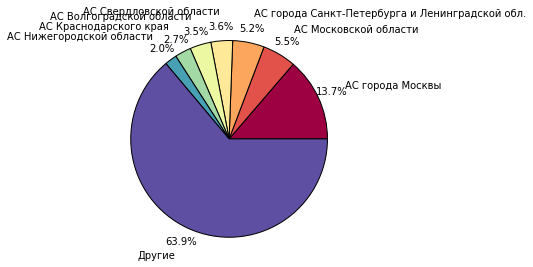

In [ ]:
group_minor_values_and_pie(df, 'Суд', 1, 7)

#### **Неисправленный boxplot**

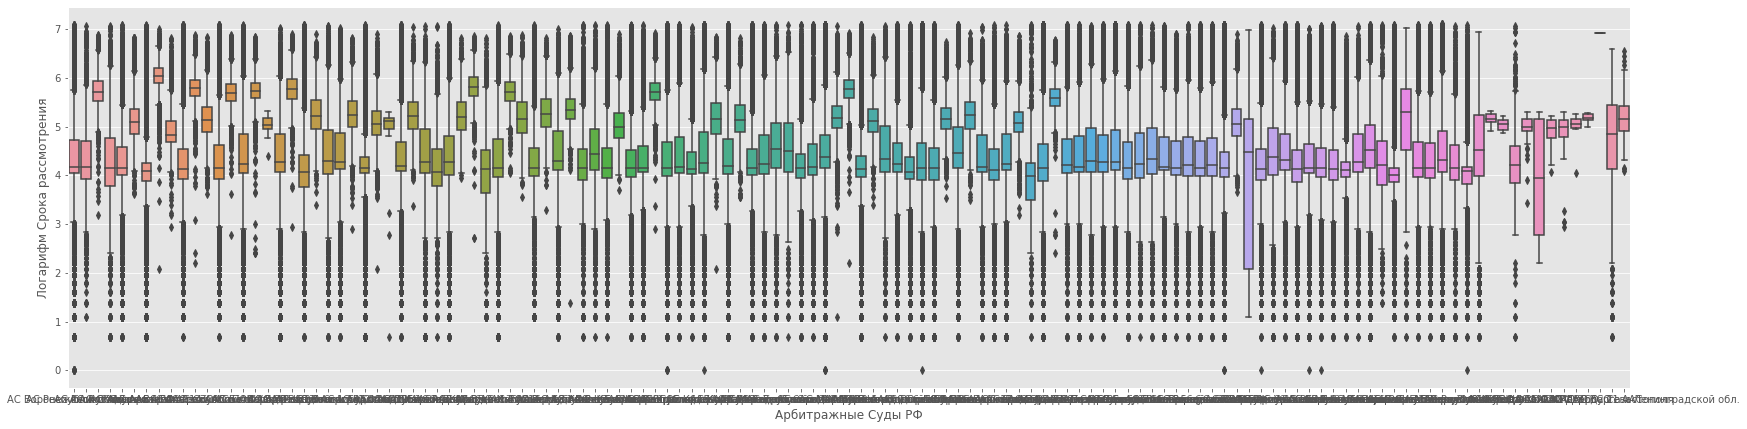

In [ ]:
#Воxplot по регионам

#если не работает, раскомментируете строку ниже
#df['Продолжительность'] = df['Продолжительность'].dt.days

columns = ['Сумма Иска', 'Сумма Взысканий', 'Продолжительность']
df_log = df[columns].apply(lambda x: np.log(x + 1)) # снова прологарифмируем
df_log['Cуд'] = df['Суд']


plt.figure(figsize=(28,7))

sns.boxplot(x='Cуд', y='Продолжительность', data=df_log)

plt.xlabel('Арбитражные Суды РФ')
plt.ylabel('Логарифм Срока рассмотрения');

**Добавить заключение**

### **О Видах и Категориях споров**

- Какая доля дел приходится на разные Виды Споров? 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


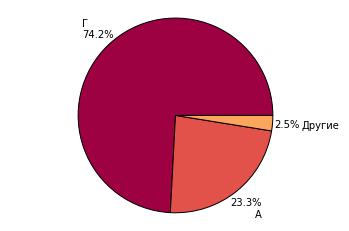

In [ ]:
group_minor_values_and_pie(df, 'Вид Спора', 2, 0.75)

In [ ]:
df['Вид Спора'].value_counts()

Г     2689958
А      845048
Б       60413
И       19270
Бф       7755
Ф        3334
Name: Вид Спора, dtype: int64

В процентах:

In [ ]:
df['Вид Спора'].value_counts() / df.shape[0] * 100

Г     74.156907
А     23.296329
Б      1.665469
И      0.531236
Бф     0.213790
Ф      0.091912
Name: Вид Спора, dtype: float64

* Какая доля дел приходится на разные категории? Каких споров больше всего?

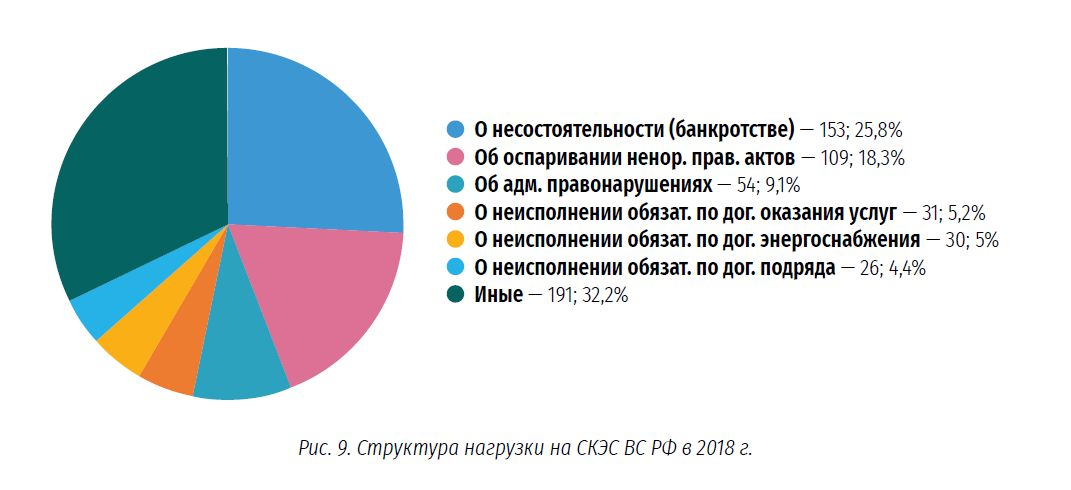

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


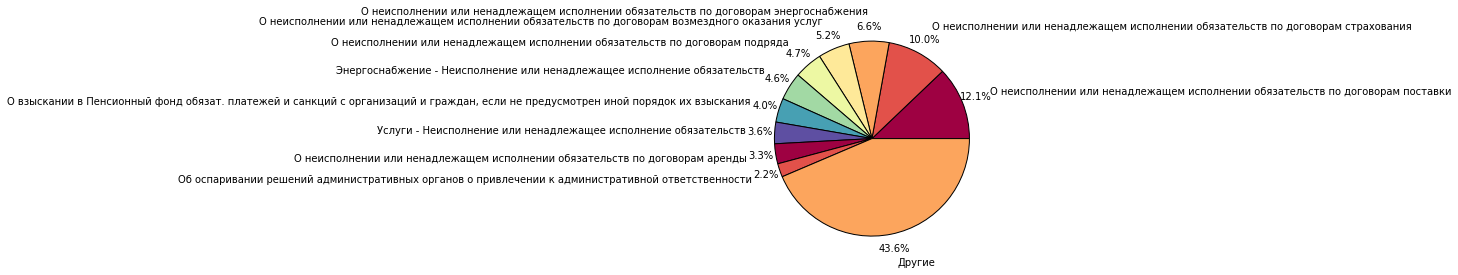

In [ ]:
group_minor_values_and_pie(df, 'Категория Спора', 1, 10)

In [ ]:
#df.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/ArbitrageCleaned.zip', index=False, compression=dict(method='zip', archive_name='APwithEndDates.csv'))

## **Заметки про функции распределения**

In [ ]:
df_categ1 = df[df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам поставки']

df_categ1.head()

,Номер Дела,Суд,Вид Спора,Категория Спора,Сумма Иска,Сумма Взысканий,Начало,Продолжительность,Конец
5,А01-124/2014,АС Республики Адыгея,Г,О неисполнении или ненадлежащем исполнении обя...,129397.0,0.0,2014-01-31,75,2014-04-16
69,А03-1566/2014,АС Алтайского края,Г,О неисполнении или ненадлежащем исполнении обя...,171330000.0,193520.0,2014-01-31,209,2014-08-28
96,А03-1594/2014,АС Алтайского края,Г,О неисполнении или ненадлежащем исполнении обя...,50647.9,50647.9,2014-01-31,81,2014-04-22
126,А03-1638/2014,АС Алтайского края,Г,О неисполнении или ненадлежащем исполнении обя...,1637370.0,0.0,2014-01-31,41,2014-03-13
128,А03-1640/2014,АС Алтайского края,Г,О неисполнении или ненадлежащем исполнении обя...,1165610.0,1061110.0,2014-01-31,48,2014-03-20


In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

sample = df_categ1['Продолжительность'].to_numpy(copy=True)
sample.sort()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


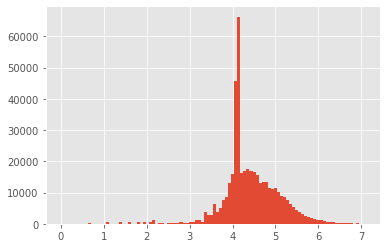

In [ ]:
plt.hist(df_categ1['Продолжительность'].apply(lambda x: np.log(x + 1)), bins=100);

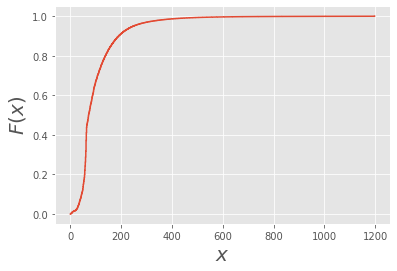

In [ ]:
ecdf = ECDF(sample)   # строим эмпирическую функцию по выборке

plt.step(ecdf.x, ecdf.y)
plt.ylabel('$F(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20);

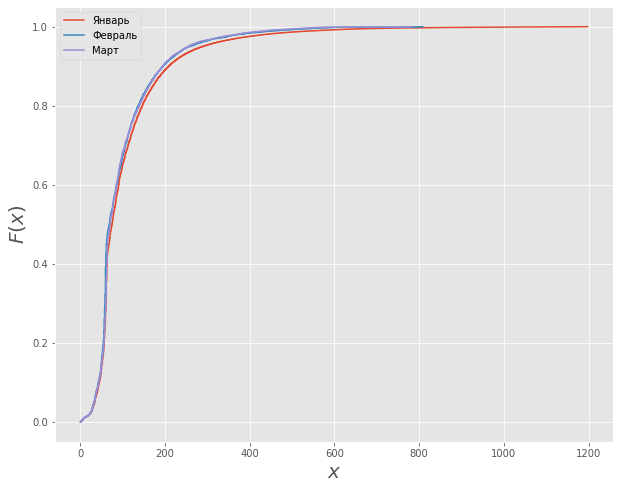

In [ ]:
plt.figure(figsize=(10,8))

s1 = df_categ1[df_categ1['Начало'] < '2015-02-01']['Продолжительность'].to_numpy(copy=True)
ecdf1 = ECDF(s1)
plt.step(ecdf1.x, ecdf1.y, label='Январь')

s2 = df_categ1[(df_categ1['Начало'] < '2015-03-01') & (df_categ1['Начало'] >= '2015-02-01')]['Продолжительность'].to_numpy(copy=True)
ecdf2 = ECDF(s2)
plt.step(ecdf2.x, ecdf2.y, label='Февраль')

s3 = df_categ1[(df_categ1['Начало'] < '2015-04-01') & (df_categ1['Начало'] >= '2015-03-01')]['Продолжительность'].to_numpy(copy=True)
ecdf3 = ECDF(s3)
plt.step(ecdf3.x, ecdf3.y, label='Март')

plt.legend(loc='best')
plt.ylabel('$F(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20);

